In [1]:
%%capture
cd ..

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection, metrics
from sklearn.datasets import make_regression
from palma import Project, ModelEvaluation, ModelSelector
from palma.components import RegressionAnalysis, ShapAnalysis
from palma.utils import plotting
X, y = make_regression(n_informative=2, n_features=10)
X, y = pd.DataFrame(X), pd.Series(y)

**Create the project**
To create vanilla project (without components), only input data $X$, target data $y$ and validation method needs to be provided.



In [3]:
project = Project(problem="regression", project_name="test")
project.start(
    X, y,
    splitter=model_selection.ShuffleSplit(n_splits=5, random_state=42),
)

Here are representation of the validation strategy

- For validation steps
- For test steps

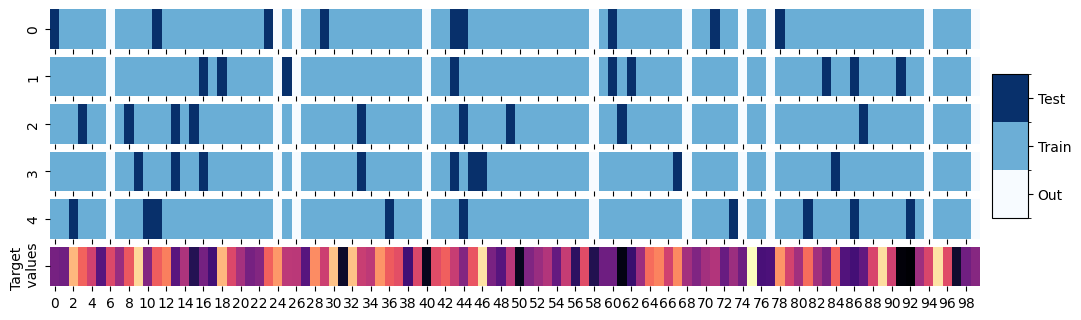

In [4]:
res = plotting.plot_splitting_strategy(
    project.X, project.y, 
    iter_cross_validation=project.validation_strategy.indexes_val, cmap="rainbow_r")

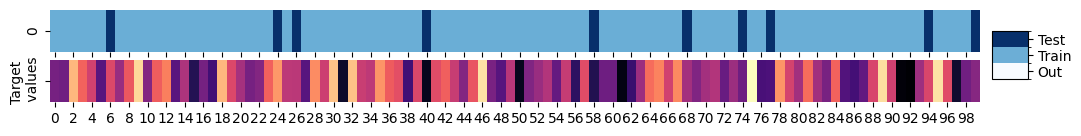

In [5]:
res = plotting.plot_splitting_strategy(
    project.X, project.y, 
    iter_cross_validation=project.validation_strategy.indexes_train_test, cmap="rainbow_r")

In [6]:
%%capture
ms = ModelSelector(engine="FlamlOptimizer",
                   engine_parameters=dict(time_budget=5))
ms.start(project)

In [7]:
model = ModelEvaluation(estimator=ms.best_model_)
model.add(RegressionAnalysis(on="indexes_val"))
model.add(ShapAnalysis(on="indexes_val", n_shap=100))
model.fit(project)

In [8]:
analyser = model.components["RegressionAnalysis"]
shap_analyser = model.components["ShapAnalysis"]

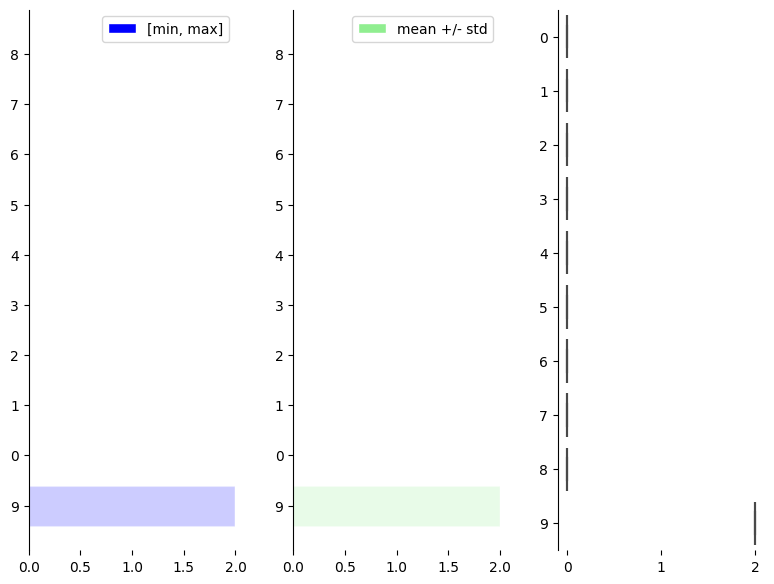

In [9]:
f, ax = plt.subplots(figsize=(8, 6), ncols=3)
plt.sca(ax[0])
analyser.plot_variable_importance(mode="minmax", color="blue")
plt.sca(ax[1])
analyser.plot_variable_importance(mode="std", color="lightgreen")
plt.sca(ax[2])
analyser.plot_variable_importance(mode="boxplot", cmap="rainbow_r")
print()

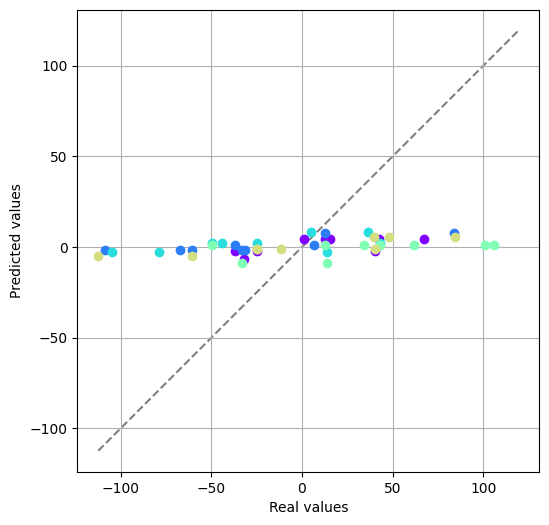

In [10]:
plt.figure(figsize=(6, 6))
analyser.plot_prediction_versus_real()

In [11]:
analyser.compute_metrics(
   { "r2": metrics.r2_score,
    "mae": metrics.mean_absolute_error,
    "mse": metrics.mean_squared_error}
)
analyser.get_test_metrics()

,r2,mae,mse
0,0.068779,27.722282,1092.696795
1,-0.152306,46.284856,3141.69482
2,-0.164555,43.470969,2710.002385
3,-0.365323,49.89147,3467.777583
4,0.111157,46.555514,2988.248359


In [12]:
most_important_var = analyser.variable_importance().T.mean().sort_values(ascending=False).index[0:3]

/home/vlaurent/Project/tools/palma/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/vlaurent/Project/tools/palma/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/vlaurent/Project/tools/palma/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


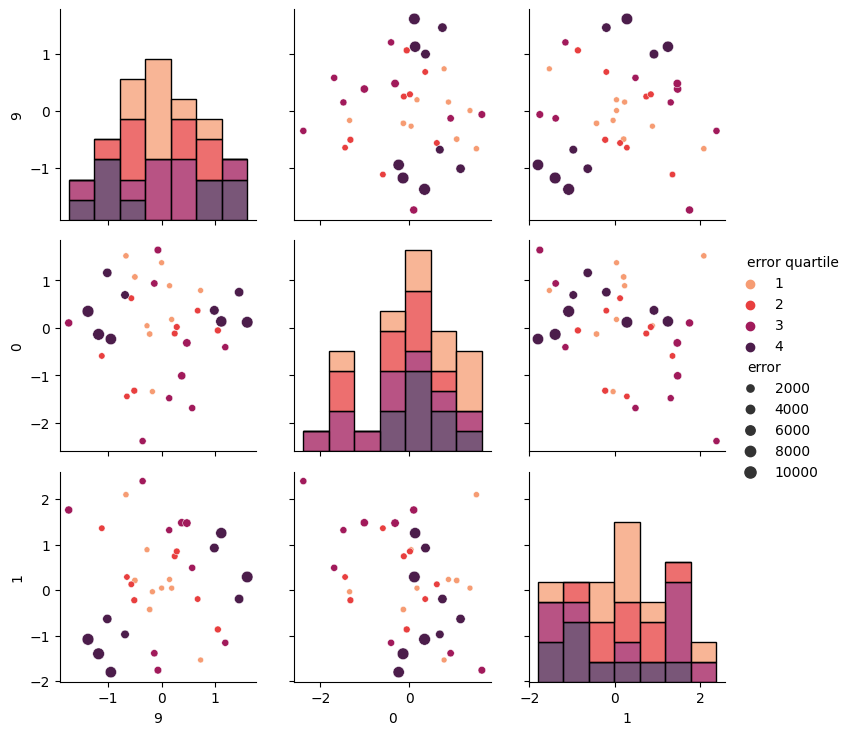

In [13]:
analyser.plot_errors_pairgrid(features=most_important_var)